In [19]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("assets\Closing_price_from_2023.csv")

In [15]:
df

,Ticker,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-09,2023-01-10,2023-01-11,2023-01-12,...,2024-12-17,2024-12-18,2024-12-19,2024-12-20,2024-12-23,2024-12-24,2024-12-26,2024-12-27,2024-12-30,2024-12-31
0,20MICRONS.BO,92.226105,92.922150,90.784302,90.436272,89.690506,90.237404,90.734581,91.480347,88.895035,...,245.949997,244.550003,240.199997,235.550003,232.000000,229.149994,227.649994,229.300003,236.100006,234.699997
1,21STCENMGM.BO,22.038528,21.796347,22.086964,21.651037,21.893219,21.747911,22.038528,21.990093,22.135401,...,88.739998,87.029999,88.699997,90.470001,89.150002,90.900002,89.099998,90.720001,89.050003,90.599998
2,3MINDIA.BO,21145.027344,21237.292969,21661.726562,21999.396484,21948.152344,22353.376953,22275.603516,21795.457031,21945.255859,...,31144.599609,30950.300781,31063.400391,30745.800781,30654.050781,30982.099609,30991.650391,30427.400391,30494.599609,30421.150391
3,63MOONS.BO,172.531006,166.355057,161.858978,163.835281,161.513123,166.058624,164.131729,161.809570,162.056610,...,943.200012,983.049988,1032.199951,980.599976,953.799988,951.150024,945.599976,906.150024,860.849976,903.849976
4,A2ZINFRA.BO,10.020000,10.180000,9.970000,10.020000,9.850000,10.150000,9.710000,9.760000,9.640000,...,23.200001,22.040001,20.940001,21.809999,22.900000,24.040001,25.240000,23.980000,23.219999,24.379999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,ZJEETMAC.BO,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,...,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000,0.680000
1115,ZODIACLOTH.BO,98.599998,99.599998,98.000000,99.500000,98.150002,99.250000,98.050003,98.050003,98.199997,...,144.050003,140.550003,142.649994,135.050003,136.699997,133.350006,132.649994,131.500000,131.149994,130.100006
1116,ZSATYASL.BO,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,...,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000,3.480000
1117,ZUARI.BO,162.550003,165.449997,162.800003,161.000000,156.949997,158.750000,155.949997,156.800003,157.199997,...,243.699997,234.050003,232.300003,221.500000,220.949997,222.500000,217.800003,215.550003,206.399994,213.399994


In [16]:
df.set_index('Ticker', inplace=True)
df = df.T

In [ ]:
stockA = df['TRITURBINE.BO']
stockB = df['KABRAEXTRU.BO']

In [22]:
def Trade(stockA,stockB):

    # --- 1. Regression to calculate beta ---
    X = sm.add_constant(stockB.values)
    y = stockA.values
    model = sm.OLS(y, X).fit()
    beta = model.params[1]

    # --- 2. Calculate spread and Z-score ---
    spread = stockA - beta * stockB
    zscore = (spread - spread.rolling(20).mean()) / spread.rolling(20).std()

    # --- 3. Generate Trading Signals ---
    signals = pd.DataFrame(index=df.index)
    signals['zscore'] = zscore
    signals['long'] = (zscore < -2)
    signals['short'] = (zscore > 2)
    signals['exit'] = (zscore.abs() < 0.5)

    # --- 4. Initialize Trade Tracking Variables ---
    entry_priceA, entry_priceB = None, None
    entry_date, entry_side = None, None
    cumulative_return = 1
    trade_log = []  # Holds all executed trades

    # --- 5. Main Trading Logic ---
    for date, signal in signals.iterrows():
        if pd.isna(signal['zscore']):
            continue  # Skip initial NaN period from rolling calculation

        # ENTRY - Long
        if signal['long'] and entry_priceA is None:
            entry_priceA = stockA[date]
            entry_priceB = stockB[date]
            entry_date = date
            entry_side = 'long'

        # ENTRY - Short
        elif signal['short'] and entry_priceA is None:
            entry_priceA = stockA[date]
            entry_priceB = stockB[date]
            entry_date = date
            entry_side = 'short'

        # EXIT - When z-score reverts
        elif signal['exit'] and entry_priceA is not None:
            exit_priceA = stockA[date]
            exit_priceB = stockB[date]

            if entry_side == 'long':
                spread_return = ((exit_priceA - entry_priceA) - beta * (exit_priceB - entry_priceB)) / (entry_priceA + beta * entry_priceB)
            else:
                spread_return = ((entry_priceA - exit_priceA) + beta * (exit_priceB - entry_priceB)) / (entry_priceA + beta * entry_priceB)

            cumulative_return *= (1 + spread_return)

            # Log the completed trade
            trade_log.append({
                'entry_date': entry_date,
                'exit_date': date,
                'side': entry_side,
                'return': spread_return
            })

            # Clear entry state
            entry_priceA, entry_priceB, entry_date, entry_side = None, None, None, None

    # --- 6. Final Cleanup - Handle Open Trade at End (if exists) ---
    if entry_priceA is not None and entry_date is not None:
        final_date = signals.index[-1]
        final_exitA = stockA[final_date]
        final_exitB = stockB[final_date]

        if entry_side == 'long':
            spread_return = ((final_exitA - entry_priceA) - beta * (final_exitB - entry_priceB)) / (entry_priceA + beta * entry_priceB)
        else:
            spread_return = ((entry_priceA - final_exitA) + beta * (final_exitB - entry_priceB)) / (entry_priceA + beta * entry_priceB)

        trade_log.append({
            'entry_date': entry_date,
            'exit_date': final_date,
            'side': entry_side,
            'return': spread_return
        })

    # --- 7. Results Summary ---
    print(f"Total Trades Executed: {len(trade_log)}")
    print(f"Final Cumulative Return: {cumulative_return:.2%}")

    # --- 8. Convert Trade Log to DataFrame ---
    trades_df = pd.DataFrame(trade_log)

    # --- 9. Calculate Cumulative Returns (Avoid Length Mismatch) ---
    cumulative_returns_series = pd.Series(
        np.cumprod(trades_df['return'].values + 1),
        index=trades_df['exit_date']
    )

    # --- 10. Plot Z-Score and Signals ---
    plt.figure(figsize=(14, 6))
    plt.plot(signals['zscore'], label='Z-Score', color='black')
    plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (+2)')
    plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
    plt.axhline(0, color='grey', linestyle=':')
    plt.legend()
    plt.title("Z-Score and Trading Signals")
    plt.grid(True)
    plt.show()

    # --- 11. Plot Cumulative Return ---
    plt.figure(figsize=(14, 6))
    cumulative_returns_series.plot(title="Cumulative Return (Based on Trades)", color='darkblue')
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()

    # --- 12. Optional - Print Trade Log for Review ---
    print("\nTrade Log:")
    print(trades_df)


Total Trades Executed: 14
Final Cumulative Return: 67.65%


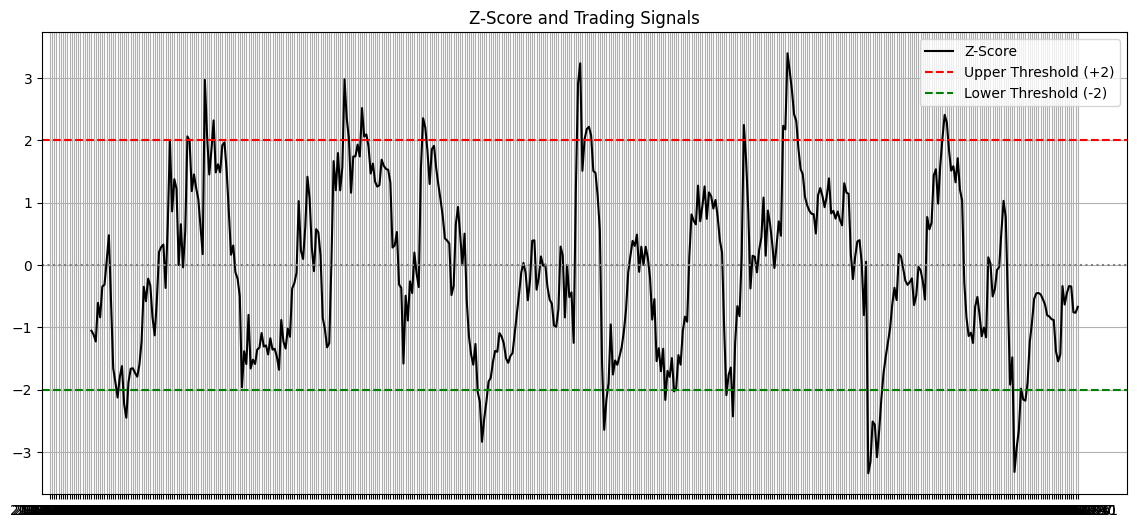

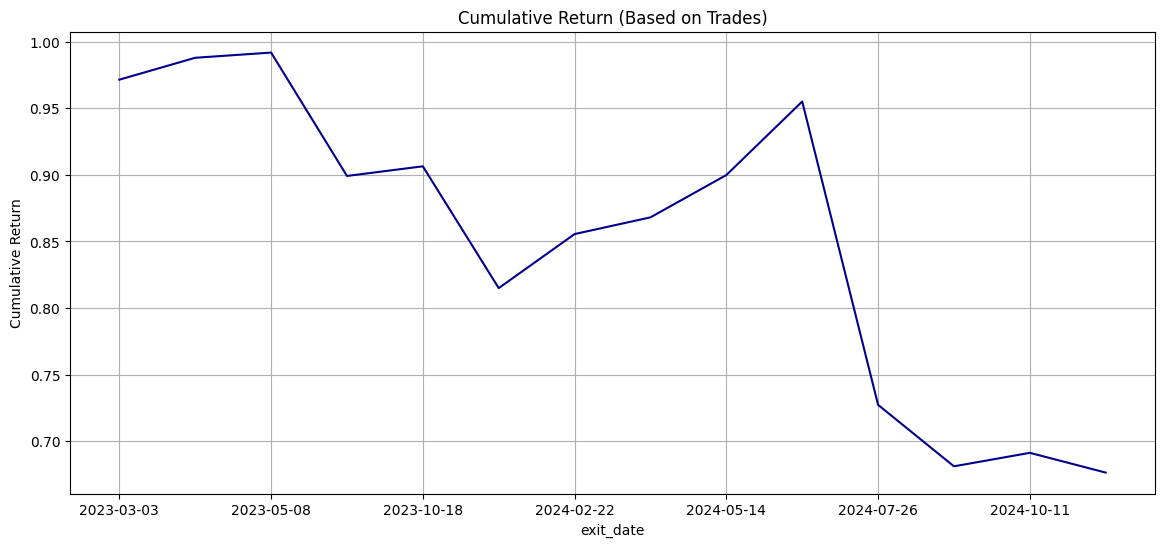


Trade Log:
    entry_date   exit_date   side    return
0   2023-02-15  2023-03-03   long -0.028567
1   2023-04-05  2023-04-18  short  0.016914
2   2023-04-19  2023-05-08  short  0.003947
3   2023-08-10  2023-09-12  short -0.093384
4   2023-10-04  2023-10-18  short  0.008044
5   2023-11-09  2023-12-08   long -0.100869
6   2024-01-17  2024-02-22  short  0.049780
7   2024-03-19  2024-04-05   long  0.014662
8   2024-05-03  2024-05-14   long  0.036587
9   2024-05-15  2024-05-21  short  0.061338
10  2024-06-11  2024-07-26  short -0.238432
11  2024-08-07  2024-08-26   long -0.063438
12  2024-09-26  2024-10-11  short  0.014861
13  2024-11-18  2024-12-03   long -0.021442


In [25]:
Trade(df["HONDAPOWER.BO"],df["TRITURBINE.BO"])

Total Trades Executed: 18
Final Cumulative Return: 88.91%


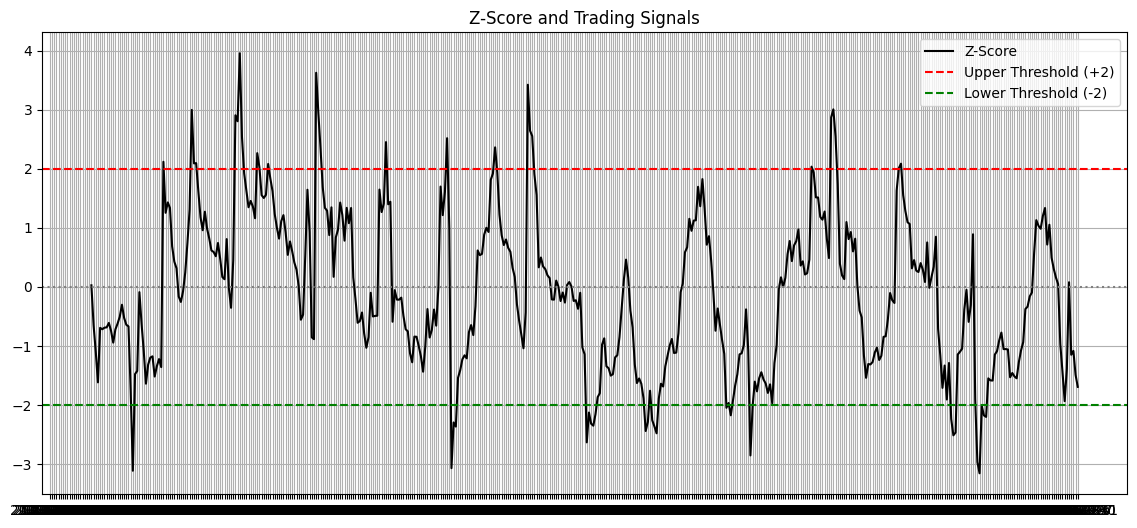

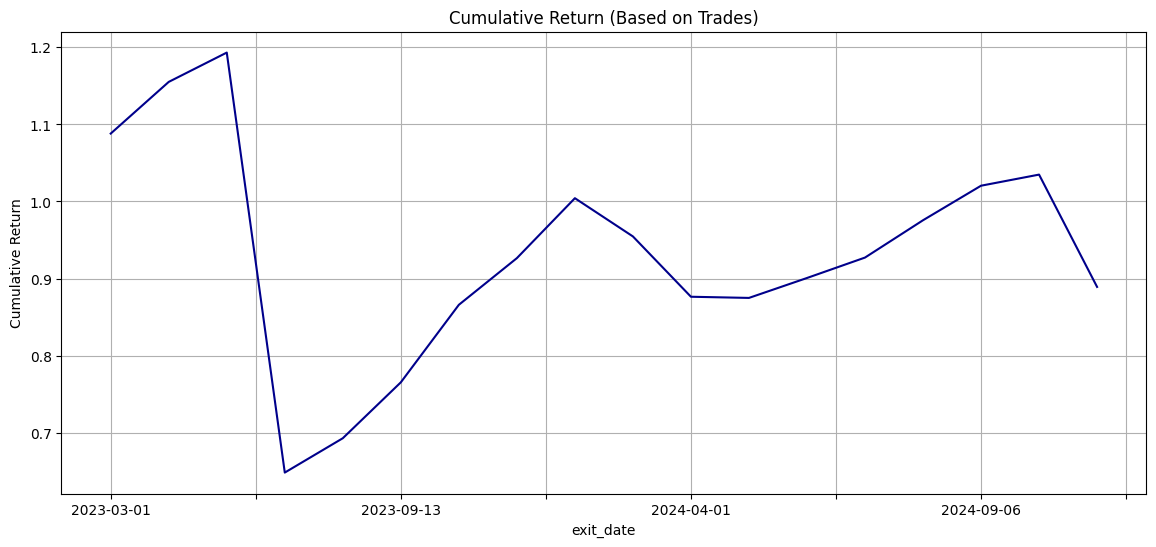


Trade Log:
    entry_date   exit_date   side    return
0   2023-02-24  2023-03-01   long  0.087939
1   2023-03-17  2023-03-24  short  0.061570
2   2023-04-10  2023-04-28  short  0.032899
3   2023-05-10  2023-06-20  short -0.456401
4   2023-07-14  2023-08-03  short  0.068682
5   2023-09-07  2023-09-13  short  0.104561
6   2023-10-19  2023-11-08  short  0.131269
7   2023-11-22  2023-12-05  short  0.069866
8   2023-12-14  2023-12-21  short  0.083871
9   2024-01-25  2024-02-19   long -0.049357
10  2024-03-05  2024-04-01   long -0.081908
11  2024-05-03  2024-05-16   long -0.001725
12  2024-05-21  2024-06-07   long  0.029513
13  2024-07-01  2024-07-11  short  0.029402
14  2024-07-12  2024-07-19  short  0.052179
15  2024-08-29  2024-09-06  short  0.045890
16  2024-10-03  2024-10-11   long  0.014107
17  2024-10-21  2024-11-26   long -0.140708


In [26]:
Trade(df["ONWARDTEC.BO"],df["ADSL.BO"])

Total Trades Executed: 13
Final Cumulative Return: 81.25%


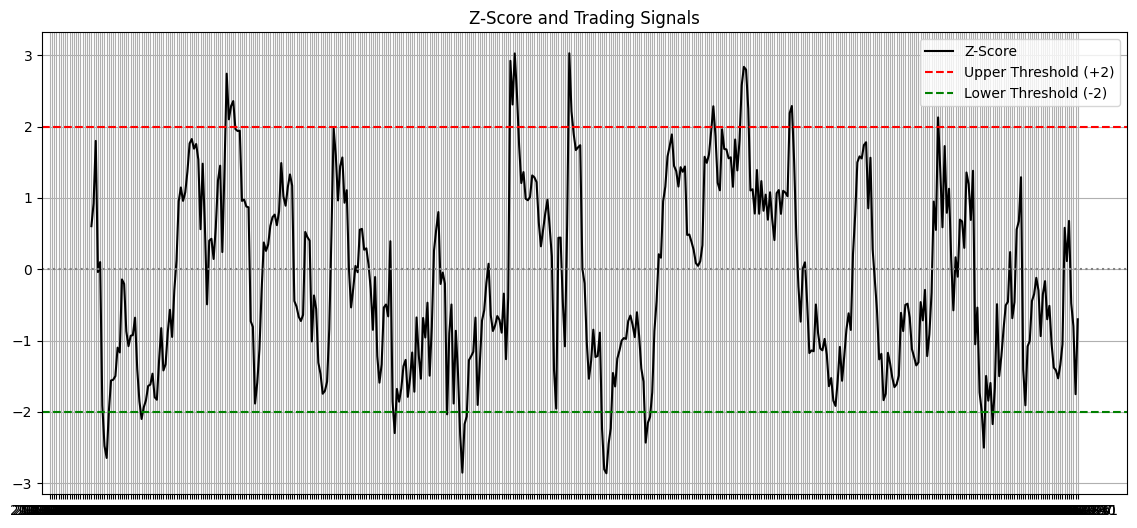

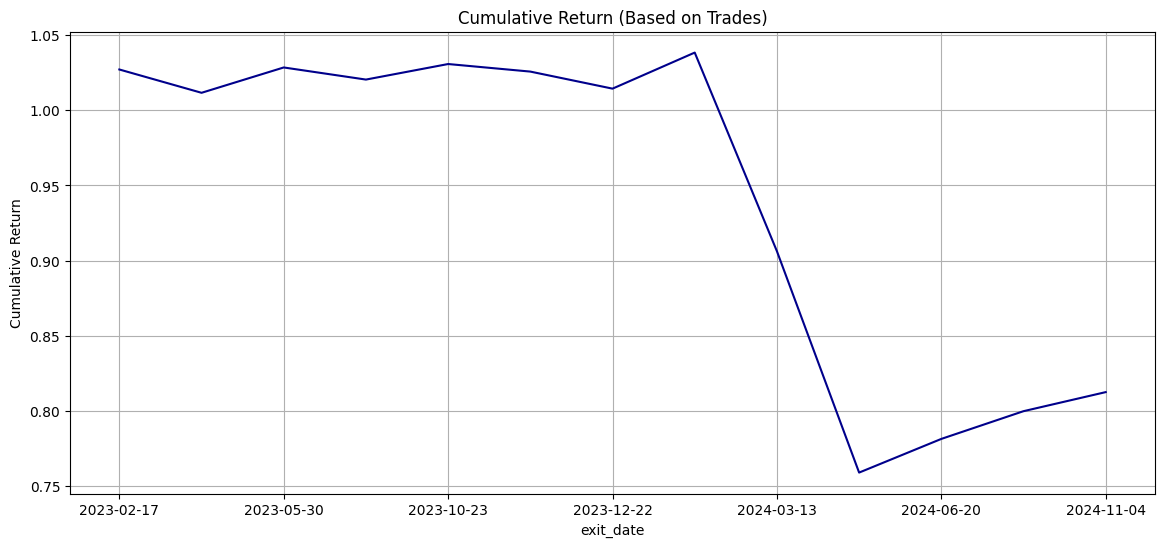


Trade Log:
    entry_date   exit_date   side    return
0   2023-02-07  2023-02-17   long  0.027037
1   2023-03-02  2023-03-24   long -0.015091
2   2023-05-04  2023-05-30  short  0.016654
3   2023-09-13  2023-10-06   long -0.007831
4   2023-10-19  2023-10-23   long  0.010130
5   2023-10-30  2023-11-16   long -0.004878
6   2023-12-04  2023-12-22  short -0.011057
7   2024-01-11  2024-01-23  short  0.023643
8   2024-02-06  2024-03-13   long -0.127224
9   2024-04-24  2024-06-05  short -0.162422
10  2024-06-14  2024-06-20  short  0.029497
11  2024-09-24  2024-10-03  short  0.023598
12  2024-10-24  2024-11-04   long  0.015850


In [27]:
Trade(df["TIMKEN.BO"],df["ELGIEQUIP.BO"])

Total Trades Executed: 18
Final Cumulative Return: 98.19%


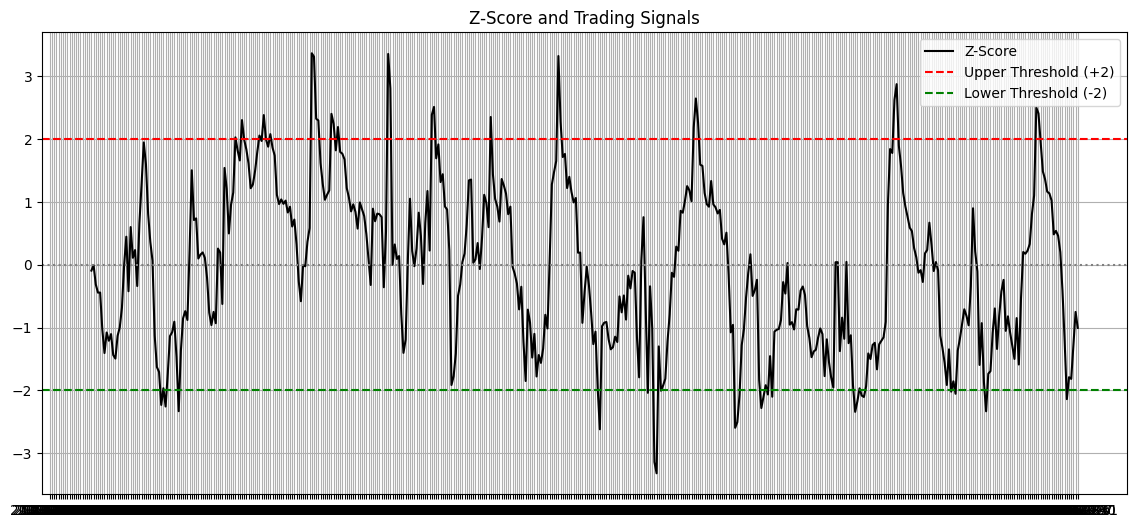

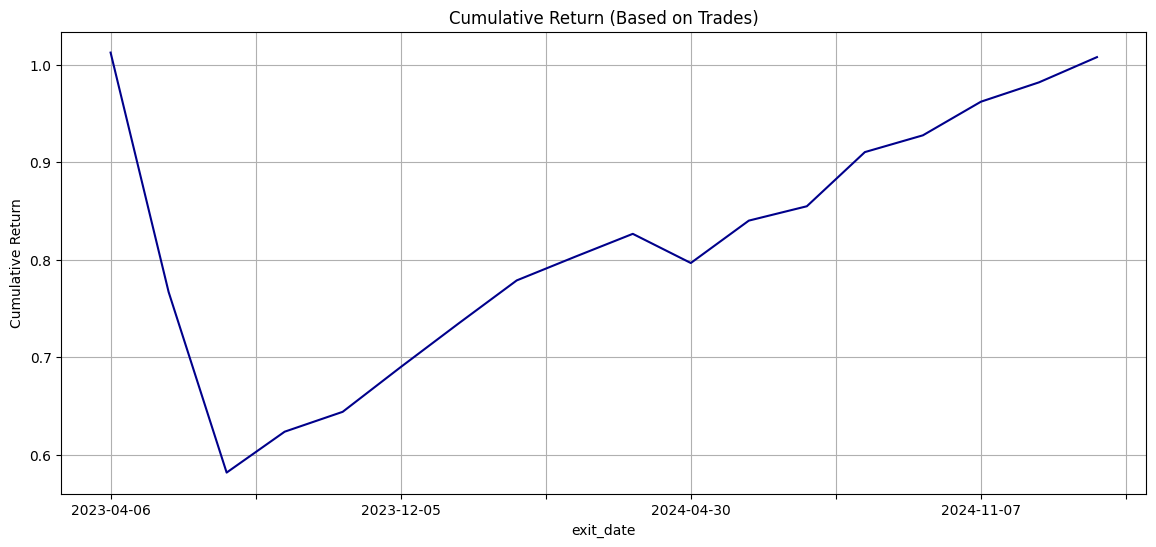


Trade Log:
    entry_date   exit_date   side    return
0   2023-03-16  2023-04-06   long  0.012412
1   2023-05-10  2023-06-21  short -0.242471
2   2023-07-07  2023-08-25  short -0.241478
3   2023-09-08  2023-09-12  short  0.072072
4   2023-10-10  2023-10-20  short  0.032668
5   2023-11-20  2023-12-05  short  0.071234
6   2024-01-04  2024-01-17  short  0.064984
7   2024-02-05  2024-02-20   long  0.059953
8   2024-03-06  2024-03-07   long  0.030965
9   2024-03-12  2024-03-22   long  0.029434
10  2024-04-09  2024-04-30  short -0.036176
11  2024-05-09  2024-05-17   long  0.054550
12  2024-05-28  2024-06-11   long  0.017531
13  2024-07-30  2024-09-09   long  0.064974
14  2024-10-03  2024-10-16   long  0.018892
15  2024-10-25  2024-11-07   long  0.037169
16  2024-12-03  2024-12-13  short  0.020596
17  2024-12-23  2024-12-31   long  0.026368


In [28]:
Trade(df["KOLTEPATIL.BO"],df["GREAVESCOT.BO"])

Total Trades Executed: 14
Final Cumulative Return: 69.90%


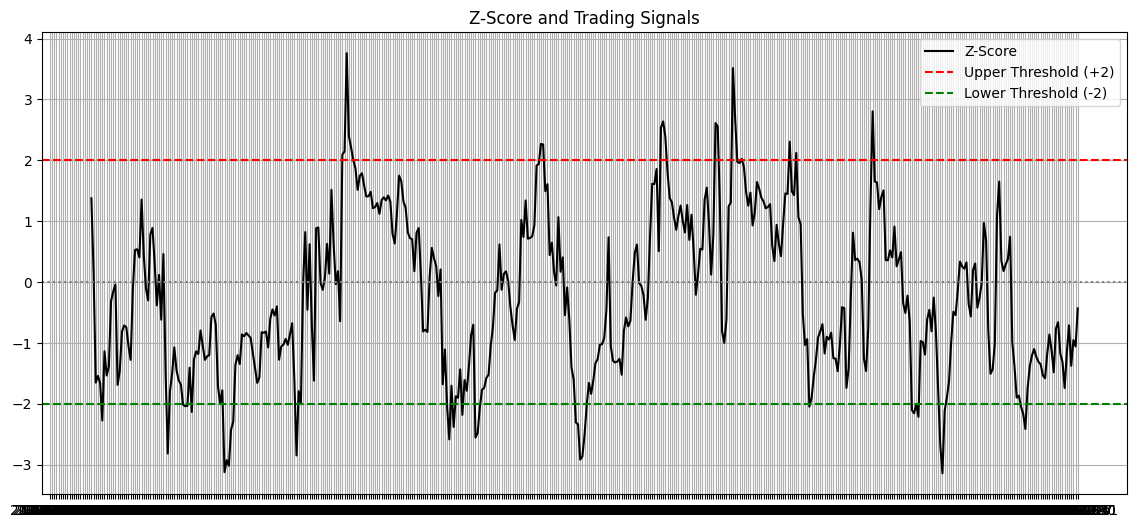

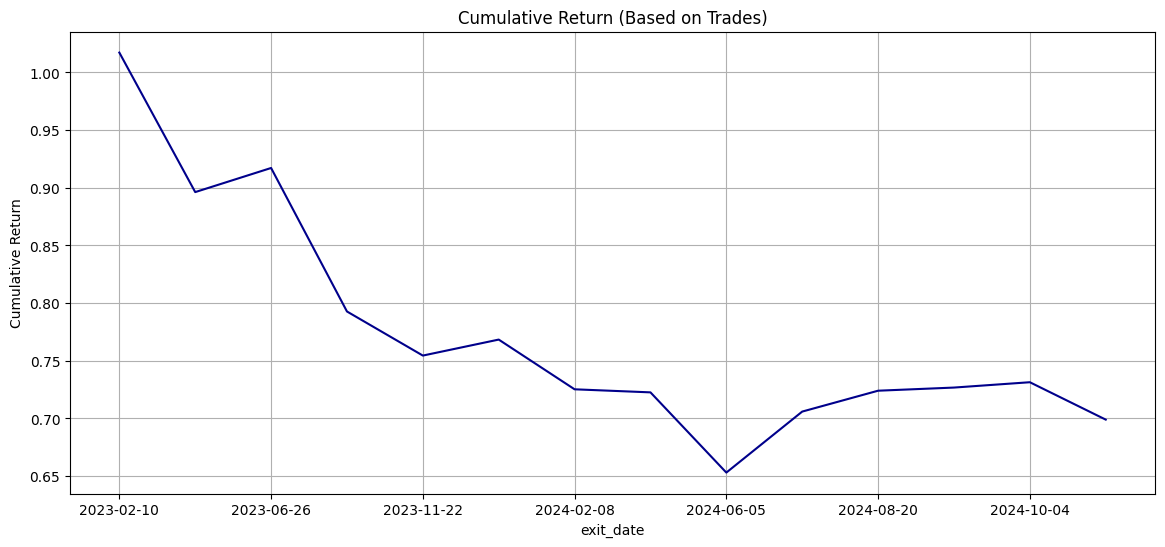


Trade Log:
    entry_date   exit_date   side    return
0   2023-02-06  2023-02-10   long  0.017166
1   2023-03-21  2023-06-06   long -0.118895
2   2023-06-21  2023-06-26   long  0.023319
3   2023-08-09  2023-09-27  short -0.135634
4   2023-10-19  2023-11-22   long -0.048212
5   2023-12-22  2023-12-29  short  0.018373
6   2024-01-16  2024-02-08   long -0.056094
7   2024-03-15  2024-04-10  short -0.003657
8   2024-04-25  2024-06-05  short -0.096228
9   2024-06-14  2024-07-22  short  0.080965
10  2024-08-09  2024-08-20  short  0.025630
11  2024-09-06  2024-09-18   long  0.003764
12  2024-09-25  2024-10-04   long  0.006364
13  2024-11-22  2024-12-31   long -0.044303


In [29]:
Trade(df["BHARATFORG.BO"],df["APOLLOTYRE.BO"])